<a href="https://colab.research.google.com/github/taltaf913/MLOps-Zoomcamp-2024/blob/main/duration_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!python -V

Python 3.10.12


In [57]:
import pandas as pd

In [58]:
import pickle

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt


In [60]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [61]:
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet

--2024-05-18 06:48:35--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 99.84.245.157, 99.84.245.9, 99.84.245.141, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|99.84.245.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47673370 (45M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2023-01.parquet.1’

yellow_tripdata_202 100%[===================>]  45.46M   131MB/s    in 0.3s    

2024-05-18 06:48:36 (131 MB/s) - ‘yellow_tripdata_2023-01.parquet.1’ saved [47673370/47673370]

--2024-05-18 06:48:36--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet
Reusing existing connection to d37ci6vzurychx.cloudfront.net:443.
HTTP request sent, awaiting response... 200 OK
Length: 47748012 (46M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2023-02.parquet.1’

yellow_t

In [62]:
df_jan = pd.read_parquet("yellow_tripdata_2023-01.parquet")
df_feb = pd.read_parquet("yellow_tripdata_2023-02.parquet")

In [63]:
print(f"There are {df_jan.columns.size} columns in the January data")

There are 19 columns in the January data


In [64]:
#Let's compute the duration of the trips, in minutes.
df_jan['duration'] = df_jan.tpep_dropoff_datetime - df_jan.tpep_pickup_datetime
df_jan.duration = df_jan.duration.apply(lambda td: td.total_seconds()/60)

In [65]:
import numpy as np
std = df_jan["duration"].std()
print(f"The standard deviation of trip durations for Jan: {np.round(std,2)}")


The standard deviation of trip durations for Jan: 42.59


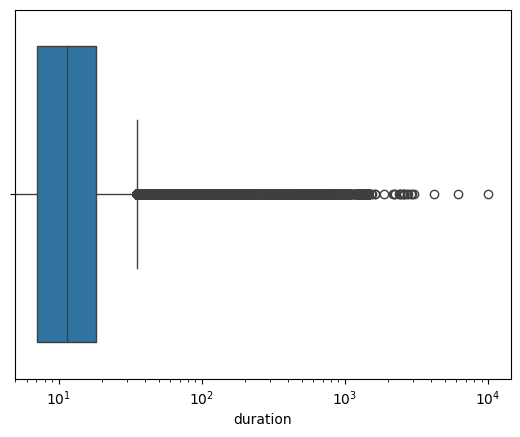

In [66]:
sns.boxplot(x=df_jan["duration"])
ax = plt.gca()
ax.set_xscale("log")

In [67]:
cond = (df_jan["duration"] >= 1) & (df_jan["duration"] <= 60)
df_jan_clean = df_jan[cond]

In [68]:
df_jan_clean = df_jan_clean.reindex()
ratio = df_jan_clean.shape[0] / df_jan.shape[0]

In [69]:
print(
    f"The fraction of records left after removing outliers is {np.round(ratio,2)*100}%"
)

The fraction of records left after removing outliers is 98.0%


In [70]:
#Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. What's the dimensionality of this matrix (number of columns)?
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

In [71]:
df_jan_clean[categorical] = df_jan_clean[categorical].astype(str)

In [72]:
train_dicts = df_jan_clean[categorical].to_dict(orient="records")
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [73]:
print(f"The number of columns in the design matrix is {X_train.shape[1]}")

The number of columns in the design matrix is 515


In [74]:
tmp1 = df_jan_clean["DOLocationID"].unique()
tmp2 = df_jan_clean["PULocationID"].unique()

In [75]:
print(
    f"Sanity check: the sum of the number of unique elements for 2 features is {tmp1.shape[0]+tmp2.shape[0]}"
)

Sanity check: the sum of the number of unique elements for 2 features is 515


In [76]:
target = "duration"
y_train = df_jan_clean[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [78]:
y_pred = lr.predict(X_train)
RMSE_train = mean_squared_error(y_train, y_pred, squared=False) # squared = False so this is root MSE (RMSE)
print(f"The RMSE on training set is {np.round(RMSE_train,2)}")

The RMSE on training set is 7.65


In [79]:
# read in the validation set
df_feb

# create a new column 'duration' in minutes
df_feb['duration'] = df_feb.tpep_dropoff_datetime - df_feb.tpep_pickup_datetime
# convert duration to seconds
df_feb.duration = df_feb.duration.apply(lambda td: td.total_seconds()/60)

# define categorical and numerical columns
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

# convert categorical columns to strings
df_feb[categorical] = df_feb[categorical].astype(str)

# remove outliers by clipping duration between 1 and 60 mins
df_feb = df_feb[(df_feb.duration >= 1) & (df_feb.duration <= 60)]

# Instantiate a dictionary vectorizer
dv = DictVectorizer()

# reinstate our training set
train_dicts = df_feb[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

# turn the categorical columns into a list of dictionaries
val_dicts = df_feb[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

# define target variable and assign to y_val
target = 'duration'
y_train = df_feb[target].values
y_val = df_feb[target].values

# instantiate & fit our model to the TRAINING set
lr = LinearRegression()
lr.fit(X_train,y_train)

# Get predictions for the VALIDATION set
y_pred = lr.predict(X_val)

# calculate RMSE
mean_squared_error(y_val, y_pred, squared=False) # squared = False so this is root MSE (RMSE)

7.778948573497093